# MNIST

The "Hello World" of machine learning.
- 70,000 images of handwritten digits.
- Scikit-Learn provides helper functions to download datasets

In [1]:
# To support python 2 and 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# Make code reproducable 
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# rc stands for run config (I think) as is a very old convention
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# Where to save figures
PROJECT_ROOT_DIR = "C:\\Users\\User\\Documents\\Data Science\\Python\\Hands_on_Machine_Learning\\handson-ml\\Projects"
PROJECT_ID = "MNIST"

def save_fig(fig_id, tight_layout=True):       
    path = os.path.join(PROJECT_ROOT_DIR, PROJECT_ID, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)    # dpi specifies resolution. digits per inch

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action = "ignore", message = "^internal gelsd")

Should use `fetch_openml()` instead of `fetch_mldata()`, although it is not sorted. Sort using the following function

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
import sklearn
sklearn.__version__

'0.20.2'

In [4]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

C:\Users\User\Anaconda3\envs\mlbook\lib\site-packages\sklearn\datasets\openml.py:58: RuntimeWarning: Invalid cache, redownloading file
  RuntimeWarning)


In [5]:
mnist.data.shape

(70000, 784)

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

70,000 images and each image has 784 features - 28 * 28 pixels. Each feature represents one pixel's intensity from 0 (white) to 255 (black). Let's have a look!

In [8]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

Saving figure some_digit_plot


<function matplotlib.pyplot.show(*args, **kw)>

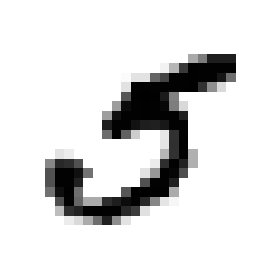

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# imshow - image show, displays arrays as images
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation = "nearest")
plt.axis("off")
save_fig("some_digit_plot")
plt.show

In [10]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
              interpolation = "nearest")
    plt.axis("off")

In [11]:
y[36000]

5

In [12]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


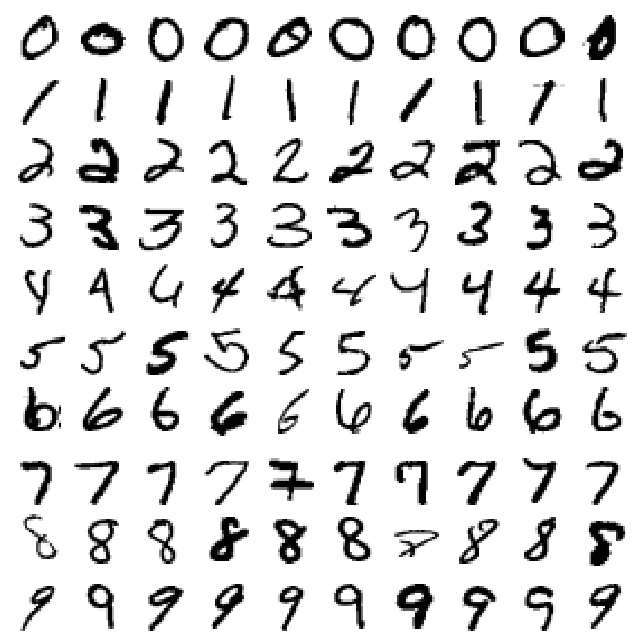

In [13]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

## Create Test Set

MNIST is actually split into training set (first 60,000 images) and test set (remaining)

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Shuffle dataset

In [15]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary Classifier

Try train a *5-Detector* - binary classifier.

Let's create a target vector

In [16]:
y_train_5 = (y_train == 5) # True for all 5's and False for others
y_test_5 = (y_test == 5)

Will begin by training a *Stochastic Gradient Descent (SGD)* classifier. 
- This classifier has the advantage of handling very large datasets efficiently. This is because it deals with instances independently, one at a time (good for online learning).

- Regular Gradient Descent uses all data points to minimize loss function - stochastic GD chooses one at random (different point each time), thus reducing computation time. 
- It's typical to start with a larger learning rate and make it smaller with each step. - *The Schedule*
- Can use mini-batch each time (3 instead of 1) - more stable.
- The algorithm relies on randomness during training - hence the name. Since we want reproducible results we should set the `random_state` parameter

**Note**: a few hyperparameters will have a different default value in future versions of Scikit-Learn, so a warning is issued if you do not set them explicitly. This is why we set `max_iter=5` and `tol=-np.infty`, to get the same results as in the book, while avoiding the warnings.

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
# Use to detect our image from earlier
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

Evaluating a classifier is significantly trickier than evaluating a regressor!

## Measuring Accuracy Using Cross-Validation

Use just like how I done in house prices project

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [20]:
# seems good at first sight but try out a naive classifier

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.909  , 0.90715, 0.9128 ])

**Better than before!!** - If you just say it will never be 5 you're right most of the time

## Confusion Matrix

Know the number of times instances of class A are classified as class B.

- Need to compare predictions to targets, since we don't want to touch our test set we can use cross validation

Just like `cross_val_score()` there is `cross_val_predict()` which performs K-fold validation but returns **predictions** made on each test fold as opposed to the **evaluation_scores**. This means *you can get a clean prediction for each instance in training set*

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [23]:
# Confusion Matrix just needs target class and predicted class
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

### Confusion Matrix

- Each row represents an *actual* class.
- Each column represents a *predicted* class.
- First row - *Negative Class*

| . |  Predicted Negative  | Predicted Positive |
| --- | --- | --- |
| **Actual Negative** | True Negatives | False Positives |
| **Actual Positive** | False Negatives | True Positives |

- *True Negatives* - Correctly classified as non-five
- *False Positives* - Wrongly classified as five (actually non-five)
- *False Negatives* - Wrongly classified as non-five (actually five)
- *True Positives* - Correctly classified as five

A more consise metric as opposed to the confusion matrix would be *precision*


### Precision

Looks at the accuracy of the positive predictions - how *precise* a classifier is

$$\text{precision} = \frac{TP}{TP + FP}$$

The more images it classifies as 5 when its not then the the less precise the model is. The more confidenet it is with it's results - the greater precision it'll have.

If you were to chose this as your metric of choice then you could have 1 instance predicted as positive with very high certainty which gives 100% precision

$$\text{precision} = \frac{TP}{TP + FP} = \frac{1}{1 + 0} = 100\%$$

This is why precision is typically used with another metric names *recall*

### Recall

Sometimes known as *sensitivity* or *true positive rate*

$$\text{recall} = \frac{TP}{TP + FN}$$

- The rate of positive instances correctly detected by the classifier

A False Negative represents a missed opportunity, something which was positive but classified as negative.

With a high precision, we miss many opportuities - or "leave things on the table". Thus, maximising the recall mean we leave nothing "on the table" but have terrible precision. i.e. we are not very confident in our results

Scikit-Learn provides several functionsto compute classifier metrics.

### F1 Score

It's useful to combine the two into 1 metric called $F_1$ score. It is the harmonic mean of the two numbers.

$$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}$$

**Why not the arithmetic mean?**

Let's say you have precision of 100% but recall of 20% in a model. Pretty crap!

If you chose a *arithmetic mean* you get

$$\frac{100 + 20}{2} = 0.60$$

which as a metric for performance doesn't really convey how bad the model is

If one choses a *harmonic mean* we'll get the following

$$\frac{2}{\frac{1}{100} + \frac{1}{20}} = \frac{2}{0.06} = 0.33$$

Thus, **to get a high $F_1$ score both precision and recall must be high**

Sometimes you may not want an $F_1$ measure to evaluate model performance.

If you built a model to detect if videos were safe for kids you would prefer one which rejects many good videos (low recall) but keeps only very safe ones (high precision).

A fraud model on the other hand may be better with low precision but high recall. Yes, there will be false alarms (low precision) but most fraudsters will be caught (high recall)

### Precision/Recall Tradeoff

For each instance a model typically computes a score based on a *decision function* with a threshold. If a score is greater than a threshold, it assigns the instance to the positive class, or else the negative class. 

The higher the threhold, the higher the precision but lower the recall.

In Scikit-Learn you can't set the threshold directly but gives you access to decision scores using the models `decision_function()` method which returns a score for each instance

In [24]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # = (4344/(4344+1307))

0.7687135020350381

In [25]:
recall_score(y_train_5, y_train_pred) # = (4344/(4344+1077))

0.801328168234643

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

Scikit-Learn doesn't allow you access to set the threshold directly but gives access to decision scores that is uses to make predictions using `decision_function()`.

This method returns scores for each instance, which then allows one to make predictions on those scores using and threshold you like.

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGD Classifier uses a threshold equal to 0, so nothing will change. Let's raise the threshold

In [29]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Thus, raising threshold reduced the recall. Since it's no longer predicted as 5 we can tell that the precision has gone up.

How can we decide on what threshold to use?
- Get scores of all instances in training set using `cross_val_predict()`.
- Specify that you want it to return decision scores instead of predictions

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, 
                             method = "decision_function")

Now with the `precision_recall_curve()` I can compute precision and recall for all possible thresholds.

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [32]:
precisions

array([0.09080706, 0.09079183, 0.09079335, ..., 1.        , 1.        ,
       1.        ])

Saving figure precision_recall_vs_threshold_plot


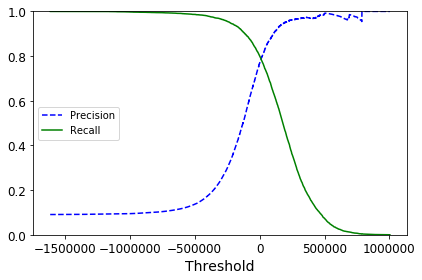

In [33]:
# Can now plot precision recall and threshold

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "center left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Looking at this, it is easy to see that the precision is quite bumpy. This is because precision can go down when threshold goes up i.e. there's a 6 that looks like a 5 but as the threshold increases that easily mistaken 6 takes up a larger proportion.

On the other hand, the lower the threshold, the more 5's we will catch, making the recall a relatively smooth curve.

Once we have this we can see what precision/recall tradeoff is best for my task. 

An alternative way to examine the tradeoff is to plot precision against recall.

Saving figure precision_vs_recall_plot


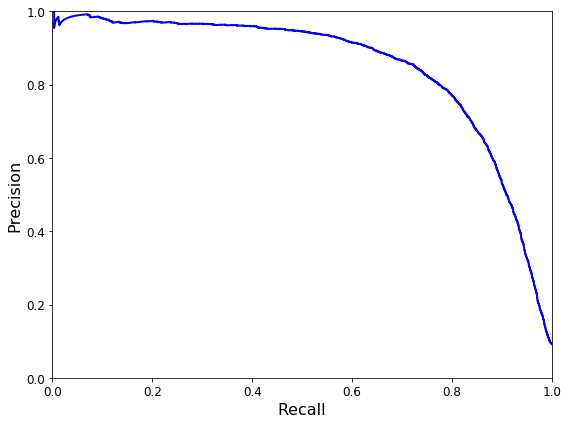

In [34]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Precision falls rapidly after 80% recall. 60% recall looks good, but this obviously depends on the project.

Let's say we want 90% precision. We would
- Identify the threshold in the 1st trade-off graph
- Run below code

In [35]:
(y_train_pred == (y_scores > 0)).all()
y_train_pred_90 = (y_scores > 70000)

Check precision and recall

In [36]:
precision_score(y_train_5, y_train_pred_90) # Giving error
recall_score(y_train_5, y_train_pred_90) # Giving error

0.6993174691016417

There are other ways of examining a classifiers performance

## The ROC Curve

*Receiver Operating Characteristic* curve is a common tool for binary classifiers.

Very similar to Precision/Recall curve but instead it plots 
- *True Positive Rate* - Recall
- *False Positive Rate* 
    - Ratio of Negative instances that are incorrectly classified as positive. All the non-Fives that were labeled as 5's.
    - Equal to 1 - *True Negative Rate* (Ratio of Negative Instances correctly Classified as negative). TNR - *Specificity*.
- Hence, ROC plots Recall vs 1 - Specificity

To plot ROC curve, you first need to compute the TPR and FPR for various threshold values, using the `roc_curve()` function.

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

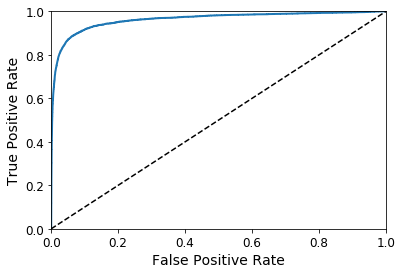

In [40]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    # plotting points (0,0) and (1,1) for straight line
    plt.plot([0, 1], [0, 1], 'k--')
    # specify x axis first, then y axis
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Remember that the *TPR* is the recall. Maximising the recall involves minimising false negatives.

There is a tradeoff with this graph.
- The higher the recall, the higher the *FPR*

The dotted line is a random classifier.

A useful way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a *ROC AUC* equal to 1 whereas the random classifer would be = 0.5

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967156

## Trying a Different Classifier

Try `RandomForestClassifier` and compare ROC curve and ROC AUC score to `SGDClassifier`

To do this we need scores for each instance in the training set - bus rndforest doesn't have a `decision_function()` method. Instead it has a `predict_proba()` method. - **Classifiers generally have one  or the other**

`predict_proba()` returns an array containing a row per instance and a column per class representing the probability that a row belongs to a particular class.



In [42]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                   method = "predict_proba")

C:\Users\User\Anaconda3\envs\mlbook\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\envs\mlbook\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\envs\mlbook\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Remember that we need scores, not probabilities.

**Solution**

Use the positive class's probability as the score:

In [44]:
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

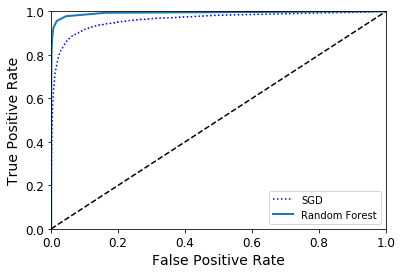

In [45]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

Very nice, what about precision and recall?

In [47]:
from sklearn.metrics import precision_recall_curve

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

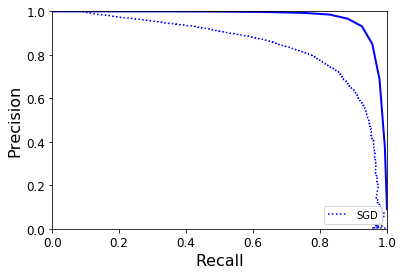

In [51]:
plt.plot(precisions, recalls, "b:", label = "SGD")
plot_precision_vs_recall(precisions_forest, recalls_forest)
plt.legend(loc = "lower right")
plt.show()

# Multiclass Classification

Also called *multinominal classifiers* - can distinguish between more than two classes

Algorithms that can handle multiple classes directly
- Random Forest Classifier
- Naive Bayes Classifier

Algorithms that cannot handle multiple classes directly - Strictly Binary
- Support vector machine classifiers
- Linear Classifiers

There are multiple strategies to perform multiclass classification using multiple binary classifiers. Take our image detection as an example

## One-Verses-All (OvA)

- Train 10 binary classifiers. A 0 detector, 1 detector etc.
- When classifying image, get decision score from each classifier and select class with highest score.
- Also called, *one-versus-the-rest*

## One-Verses-One

- Train classifier for every pair of digits. One to distinguish 0's and 1's, another to distinguish 0's and 2's and so on.
- If there are N classes you'll need to train $N \times (N-1)/2$ classifiers. $\Rightarrow$ 45 classifiers
